# Imports

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill
# import datetime

import itertools

In [2]:
%matplotlib inline

In [3]:
dill.load_session('cache/Reduced_model_LD_only.db')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

In [4]:
data_path = 'data/prepared/LD_only/'

In [5]:
results_path = 'vector/results_LD_only/Reduced_model/'

# Data reading

## Reading

### Synth data for model building

In [6]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

### Real data for analysis

In [7]:
conditions = ['LD']

In [9]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [10]:
X_real['LD']

AP1     FD  FTa1  FTa2  FTa3  FTb  FTc    LFY   TFL1a   TFL1c  days
0     2  31.53     2     8   0.9    3    0    6.4  22.021  25.556     9
1     0  47.62     0    11   0.5    7    0   12.1  20.489  25.263    11
2     6  45.41     1    29   0.8    6    0   21.4  27.397  32.982    13
3     5  40.89     5    60  10.2   28    0   56.8  33.074  39.708    15
4    23  79.47     9    50   1.3   12    0   77.1  42.561  32.222    17
5    33  71.69    40    86   2.5   58    0   48.9  54.798  67.895    20
6     1  25.86    10    18   3.4    7    0   16.0   8.314  11.930    22
7    92  43.31    10    68   4.7  127    0   45.1  18.325  25.731    25
8    19  45.20    10    37   2.1   61    0   27.7  15.851  18.713    28
9   355  81.78     6    52  14.8  102   14   50.9  22.232  29.766    30
10  117  36.26     1    16   3.0   13    0   63.7  11.323  15.029    32
11  649  63.59    29    62  90.4  140    0  124.2  24.033  31.462    34
12  691  81.78     6    34   6.8   25    0  126.1  15.465  19.240    37

In [11]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [40]

### STDs

In [7]:
stds = {}
for cond in conditions:
    stds[cond] = pd.read_csv('data/prepared/' + f'stds_{cond}.csv')
    stds[cond] = stds[cond].drop(0)
    stds[cond] = stds[cond].drop(FTs, axis = 1)

## Check the data

In [12]:
X_train.tail()

AP1          FD       FTa1        FTa2        FTa3         FTb  \
9745  784.488443   67.292099  61.953509   71.739193   76.292785  162.794571   
9746  388.881380   64.066699  92.285815   74.474846   52.342185  191.752441   
9747  613.733857   83.226798  35.892375  101.167550   90.856119  238.313221   
9748  608.648616  104.177300  64.719130   94.885832   75.188790  128.230406   
9749  673.255484   71.940803  56.351508  125.470730  106.446335  164.182441   

            FTc         LFY      TFL1a      TFL1c  days  
9745  65.664346   83.617864  16.775403  22.075476    37  
9746  60.787867   19.315750  18.542455  17.609182    37  
9747  97.894605   65.724402  16.518412  20.748802    37  
9748  33.018027   89.760888  17.707894  23.255400    37  
9749  49.295557  109.603483  16.162306  20.206275    37

In [13]:
X_train.days.value_counts()

15    750
30    750
22    750
37    750
13    750
28    750
20    750
11    750
34    750
25    750
17    750
9     750
32    750
Name: days, dtype: int64

In [14]:
Y_train.tail()

AP1          FD         LFY      TFL1a      TFL1c  days
9745   686.669585  132.591502   81.210510  14.432262  33.341479    40
9746   918.815009  110.296230   92.186444  13.367673  42.642787    40
9747   742.434906  137.745811  114.042272  15.128368  19.433130    40
9748  1139.814326  134.340548   49.470184  15.898169  35.749122    40
9749  1081.628355  135.388366   31.495025  14.847826  45.300037    40

In [15]:
days = list(set(X_test.days.values))
days.append(40)
days.sort()
days

[9, 11, 13, 15, 17, 20, 22, 25, 28, 30, 32, 34, 37, 40]

In [16]:
X = X_train.drop('days', axis=1)
Y = Y_train.drop('days', axis=1)

In [17]:
targets = Y.columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [18]:
X_test.tail()

AP1         FD       FTa1       FTa2        FTa3         FTb  \
3245  717.896390  68.781685  31.221523  69.941146   55.369299  162.619618   
3246  770.673508  57.126454  26.509988  71.966431  124.982182   88.550417   
3247  562.965339  97.753323  52.430869  91.312769   33.889742  215.362056   
3248  480.583262  73.249377  20.691625  85.331752   87.712742  204.219485   
3249  773.450041  55.453464  81.785232  77.069958  105.354443  162.338370   

            FTc         LFY      TFL1a      TFL1c  days  
3245  43.385537   46.101507  16.403900  22.793783    37  
3246   7.205752  149.987752  15.434570  13.265760    37  
3247  43.959744  166.317300  14.309961  19.516682    37  
3248  38.201311  117.048627  16.364967  19.856929    37  
3249  74.829069  147.448367  19.069992  20.527455    37

# Random forest

In [19]:
genes = X_test.drop('days', axis = 1).columns.tolist()
targets = [name for name in genes if not name.startswith('FT')]
FTs = sorted(list(set(genes) - set(targets)))

In [20]:
regulators = {
    'AP1': genes[1:],
    'FD': ['LFY'],
    'LFY': genes.copy(),
    'TFL1a': ['AP1'],
    'TFL1c': ['AP1']
}

regulators['LFY'].remove('LFY')

## Model building

In [21]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

### Rough tuning

In [22]:
cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [50, 100, 300, 350],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 8, 20, None]
}

In [23]:
model = {}
gs = {}

for t in targets:
    model[t] = RandomForestRegressor()
    gs[t] = GridS(model[t], grid, cv)

In [24]:
for t in targets:
    gs[t].fit(X[regulators[t]].values, Y[t].values)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [25]:
for t in targets:
    print(t , gs[t].best_params_)

AP1 {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 350}
FD {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 300}
LFY {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 350}
TFL1a {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 350}
TFL1c {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}


In [26]:
best_model = {}

for t in targets:
    best_model[t] = gs[t].best_estimator_

### Fine tuning (?)

In [ ]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [250, 300, 350],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [15, 20, 25, None]
}

In [ ]:
gs = GridS(model, grid, cv)

In [ ]:
gs.fit(X.values, Y.values)

In [ ]:
gs.best_params_

In [ ]:
gs.score

Get the model with best score on the cross-validation:

In [ ]:
best_model = gs.best_estimator_

### Save the model

In [27]:
with open('cache/Reduced_model_LD_only.md', 'wb') as ouf:
    dill.dump(best_model, ouf)

## Make predictions

In [28]:
def predict(data):
    predictions = pd.DataFrame()
    
    for t in targets:
        predictions[t] = best_model[t].predict(data[regulators[t]].values)
        
    return predictions

In [29]:
predictions_train = predict(X)
predictions_test = predict(X_test.drop('days', axis=1))

## Evaluating

In [13]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions.values, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions.values, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.values.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets, )
    return df

In [5]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0], s=3, format='svg'):
    plt.scatter(true_values, predictions, s=s)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    plt.savefig(results_path + current_target + '_' + data_type + f'.{format}', bbox_inches='tight', format=format, dpi=300)
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [14]:
print_scores(Y, predictions_train)

MSE  NRMSE    R2     r
AP1    13075.36  0.050  0.89  0.94
FD       464.70  0.108  0.34  0.59
LFY      467.68  0.077  0.76  0.88
TFL1a    156.83  0.125  0.17  0.41
TFL1c    216.13  0.139  0.08  0.29

Scores on test:

In [15]:
print_scores(Y_test.drop('days', axis=1), predictions_test)

MSE  NRMSE    R2     r
AP1    21902.47  0.075  0.80  0.90
FD       467.57  0.117  0.36  0.60
LFY      795.08  0.113  0.63  0.80
TFL1a    163.08  0.141  0.15  0.39
TFL1c    218.03  0.163  0.07  0.26

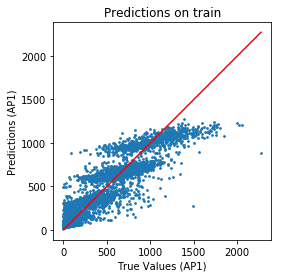

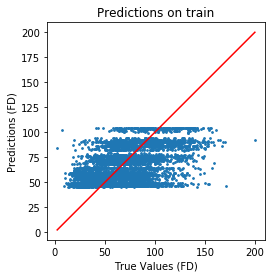

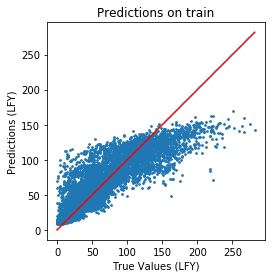

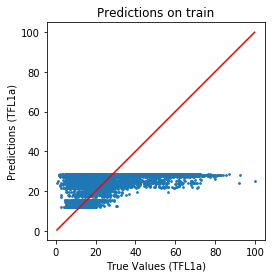

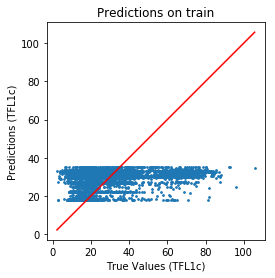

In [6]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train.iloc[:, i], data_type='train', current_target=targets[i])

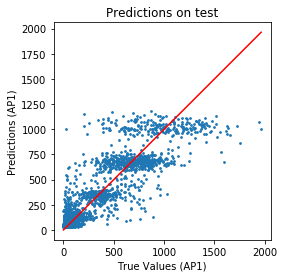

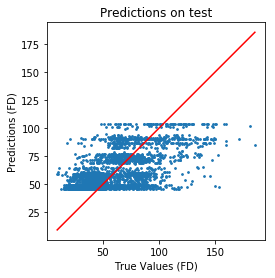

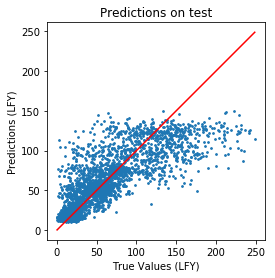

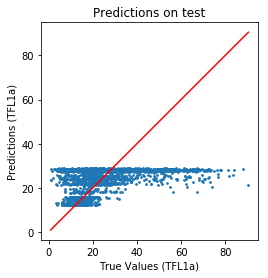

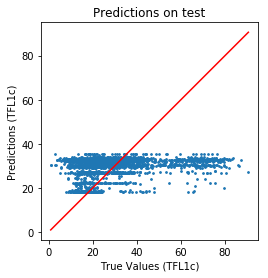

In [7]:
for i in range(5):
    comparsion_plot(Y_test.drop('days', axis=1).iloc[:, i], predictions_test.iloc[:, i], data_type='test', current_target=targets[i])

## Feature importances

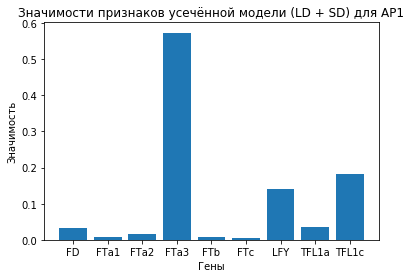

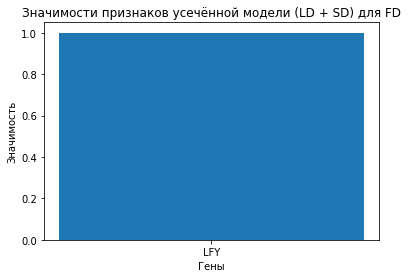

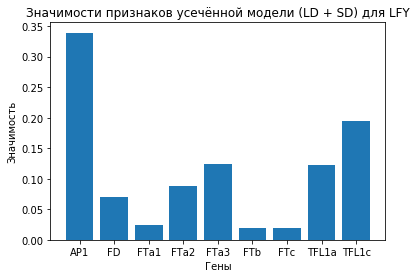

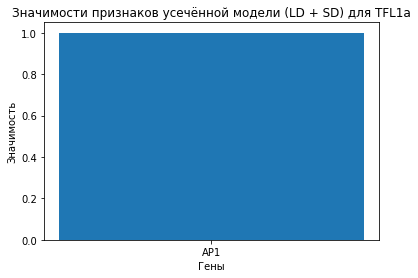

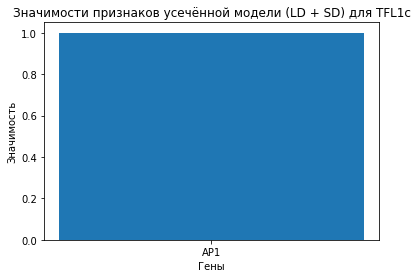

In [10]:
for t in targets:
    plt.bar(x = regulators[t], height = best_model[t].feature_importances_)
    plt.title(f'Значимости признаков усечённой модели (LD + SD) для {t}')
    plt.xlabel('Гены')
    plt.ylabel('Значимость')
    plt.savefig(results_path + f'/feature_importances/{t}_FI')
    plt.show()

# Real data

In [14]:
def time_long_plot(true_values, predicted, condition = 'LD', predict_method = 'static'):
    
    for i in range(5):
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(true_values['days'], predicted.iloc[:, i].values, '-')
        
        plt.title(targets[i] + ' ' + condition + f' ({predict_method} prediction method)')
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions', 'true values'])
        
        fig_path = results_path + predict_method + '/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'/{targets[i]}_{condition}_pred_on_real.svg', 
                    bbox_inches='tight', format='svg')
        plt.show()

## Static

In [12]:
predictions_real = {}
predictions_real['LD'] = predict(X_real['LD'].drop('days', axis=1))

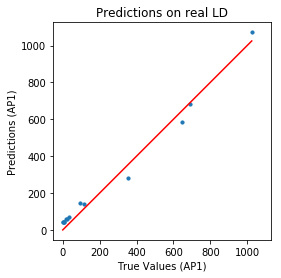

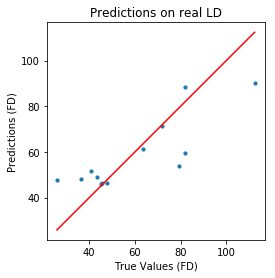

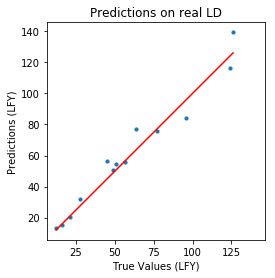

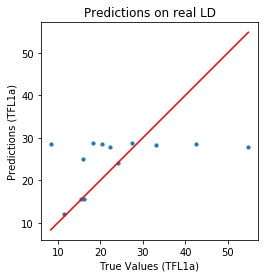

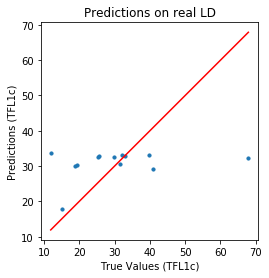

In [10]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real ' + cond, current_target=targets[i], s=10)

In [17]:
print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond])

MSE  NRMSE    R2     r
AP1    2002.79  0.044  0.98  0.99
FD      189.37  0.122  0.66  0.84
LFY      56.08  0.059  0.96  0.98
TFL1a   126.64  0.205  0.19  0.44
TFL1c   176.05  0.195  0.08  0.30

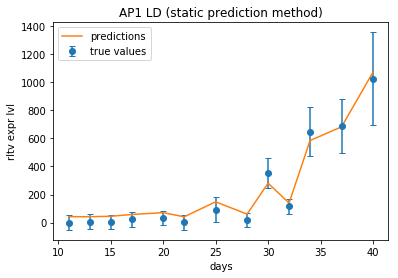

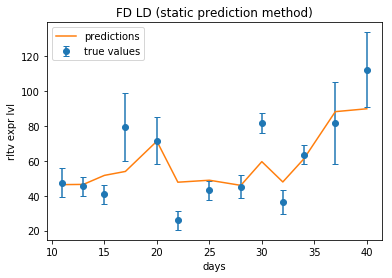

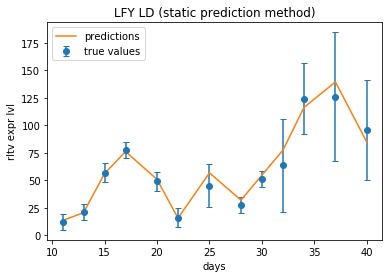

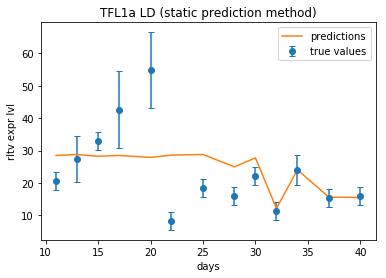

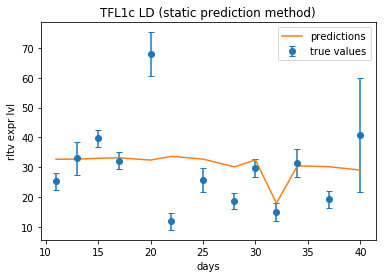

In [15]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

## Dynamic

In [17]:
predictions_real['LD']

AP1         FD         LFY      TFL1a      TFL1c
0    41.851651  46.411948   13.395854  28.489063  32.701899
1    46.647949  47.645078   49.552624  28.113524  33.183149
2    50.171528  47.842655   57.469741  28.267837  32.773241
3    54.024072  55.447879   63.049186  28.126081  32.926992
4    54.171785  62.216725   53.206875  28.116349  32.980576
5    81.627700  49.227940   52.121004  28.111885  32.980576
6    52.010234  48.856879   54.870304  24.386496  30.243494
7    55.628463  49.183728   41.581947  28.049333  32.831588
8    49.142147  46.325089   57.187485  28.060850  32.895550
9    48.151743  54.695500   62.982997  28.077767  32.950594
10   52.961894  62.259066   53.649963  28.061094  32.950594
11  651.953994  49.209050   65.475615  28.052211  32.853796
12   48.900376  65.481777  103.112329  15.601859  30.199882

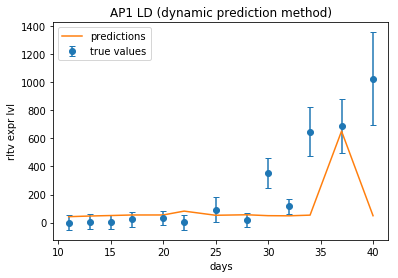

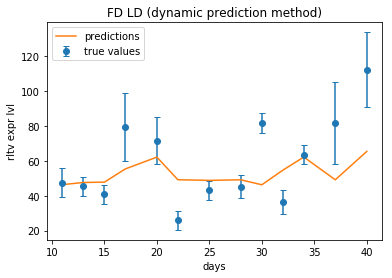

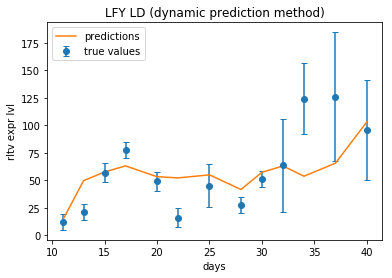

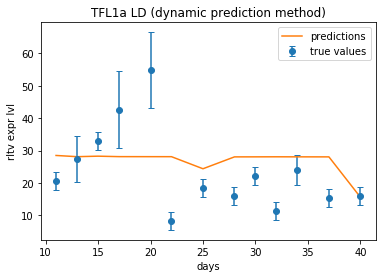

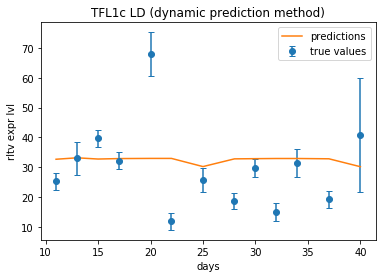

In [16]:
for cond in conditions:

    X_temp = X_real[cond].drop('days', axis = 1)

    predictions_real[cond] = pd.DataFrame(columns=targets)

    for i in X_real[cond].index:
        current_predictions = predict(X_temp.loc[[i]])
        predictions_real[cond] = predictions_real[cond].append(current_predictions, ignore_index = True)
        X_temp[targets] = current_predictions.values[0]

    time_long_plot(Y_real[cond], predictions_real[cond], cond, 'dynamic')

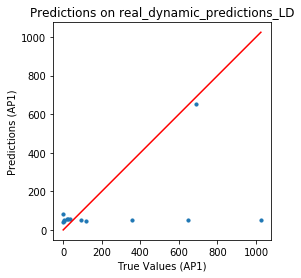

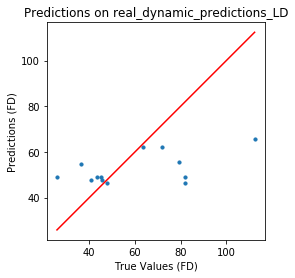

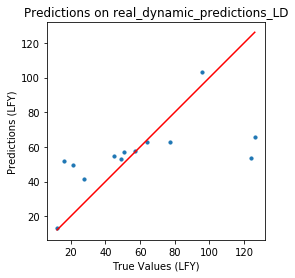

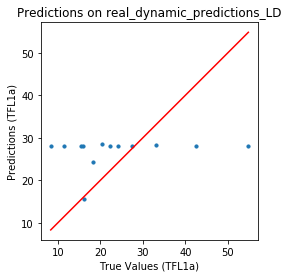

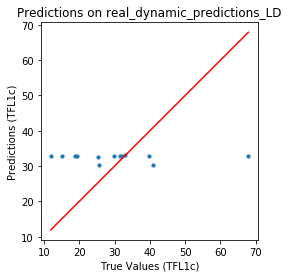

In [13]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real_dynamic_predictions_' + cond, current_target=targets[i], s=10)

In [19]:
print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond])

MSE  NRMSE    R2     r
AP1    109549.41  0.323 -0.02  0.39
FD        474.80  0.194  0.14  0.55
LFY       873.17  0.234  0.34  0.60
TFL1a     159.61  0.231 -0.02  0.22
TFL1c     201.41  0.209 -0.05 -0.08

# Knock out simulation

## Methods definitions

In [19]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic', format='svg'):
    x_axis = true_values['days']
    
    for i in range(5):        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
            
        plt.plot(x_axis, predicted.iloc[:, i], '--')
        plt.plot(x_axis, pred_for_ko.iloc[:, i], '-')
        
        if type(KO_gene) == type(''):
            KO_name = KO_gene
        else:            
            KO_name = '_'.join(KO_gene)

        plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
        
        if type(KO_gene) != type(''):
            KO_number = len(KO_gene)
        else:
            KO_number = 1
        
        fig_path = results_path + f'{predict_method}/KOs/{targets[i]}/{KO_number}/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_with_{KO_gene}_KO.svg', 
                    bbox_inches='tight', format = 'svg')
        plt.show()

## KO Iterations set

In [47]:
targets_with_cond = [name + '_LD' for name in targets]

In [48]:
targets_with_cond

['AP1_LD', 'FD_LD', 'LFY_LD', 'TFL1a_LD', 'TFL1c_LD']

In [49]:
genes = X_real['LD'].drop('days', axis=1).columns.tolist()

In [50]:
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [51]:
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [52]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

In [53]:
def FTs_combos(massive = FTs, number = 2):
    
    FTset = []
    comb = list(itertools.combinations(massive, number))
    
    for c in comb:
        FTset.append(list(c))

    return FTset

In [54]:
FT_pairs = FTs_combos(FTs, 2)
FT_pairs

[['FTa1', 'FTa2'],
 ['FTa1', 'FTa3'],
 ['FTa1', 'FTb'],
 ['FTa1', 'FTc'],
 ['FTa2', 'FTa3'],
 ['FTa2', 'FTb'],
 ['FTa2', 'FTc'],
 ['FTa3', 'FTb'],
 ['FTa3', 'FTc'],
 ['FTb', 'FTc']]

In [55]:
FT_trios = FTs_combos(FTs, 3)
FT_trios

[['FTa1', 'FTa2', 'FTa3'],
 ['FTa1', 'FTa2', 'FTb'],
 ['FTa1', 'FTa2', 'FTc'],
 ['FTa1', 'FTa3', 'FTb'],
 ['FTa1', 'FTa3', 'FTc'],
 ['FTa1', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb'],
 ['FTa2', 'FTa3', 'FTc'],
 ['FTa2', 'FTb', 'FTc'],
 ['FTa3', 'FTb', 'FTc']]

In [56]:
FT_quads = FTs_combos(FTs, 4)
FT_quads

[['FTa1', 'FTa2', 'FTa3', 'FTb'],
 ['FTa1', 'FTa2', 'FTa3', 'FTc'],
 ['FTa1', 'FTa2', 'FTb', 'FTc'],
 ['FTa1', 'FTa3', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb', 'FTc']]

In [57]:
KO_iterations = [targets, FTs, FT_pairs, FT_trios, FT_quads]

## KO simulations

In [15]:
AUC = pd.DataFrame(0, index=targets_with_cond, columns=['WT'])

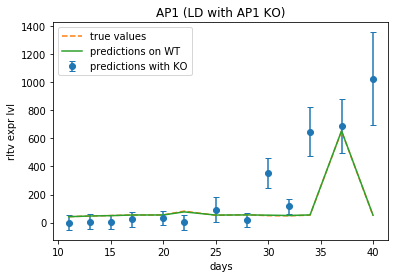

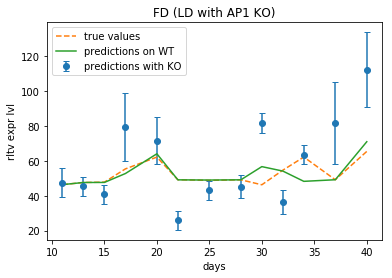

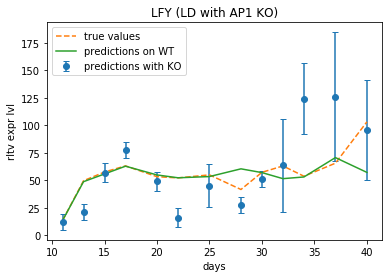

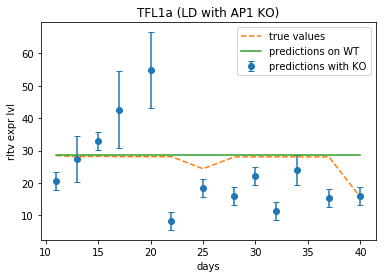

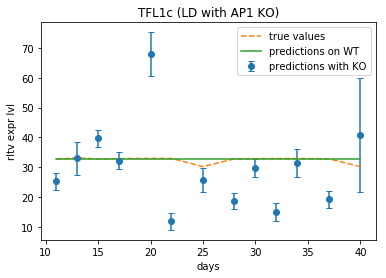

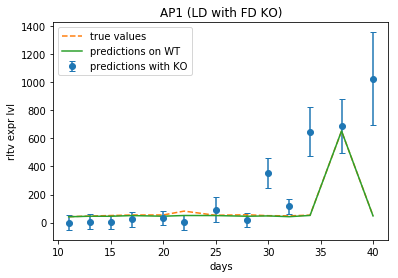

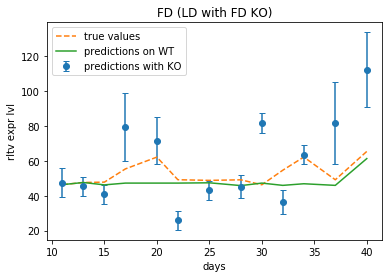

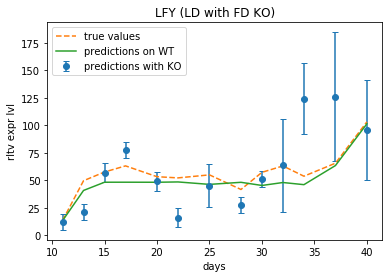

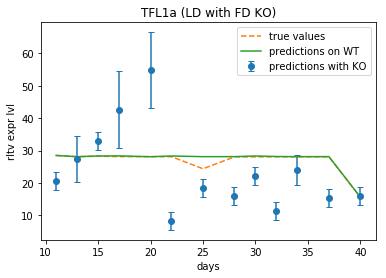

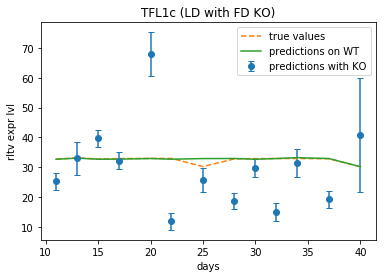

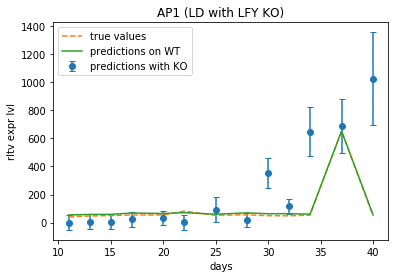

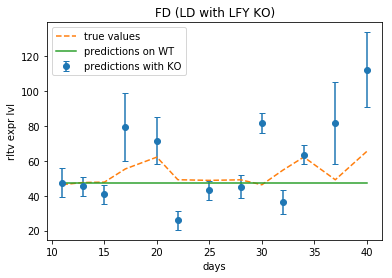

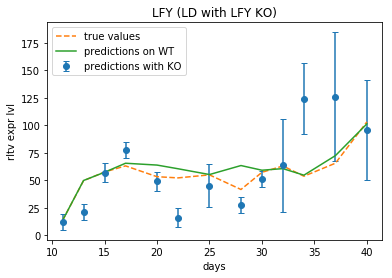

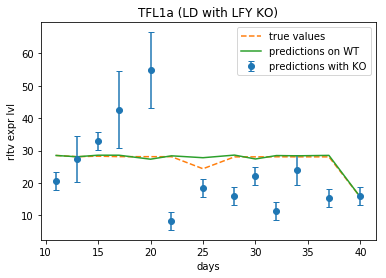

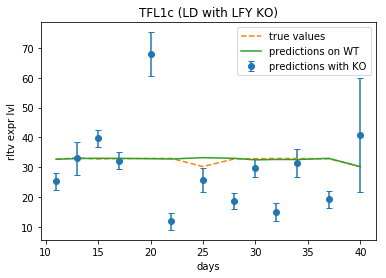

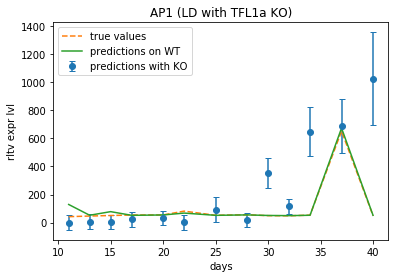

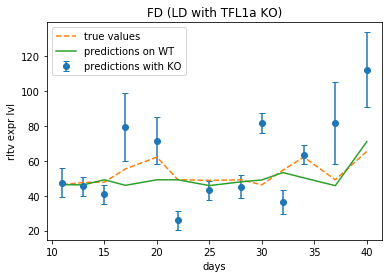

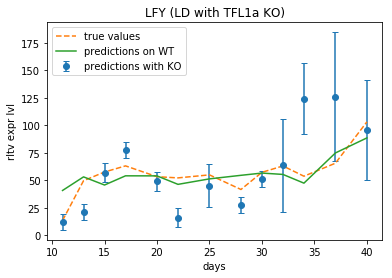

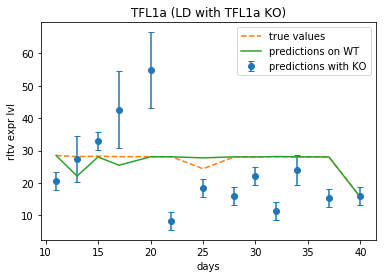

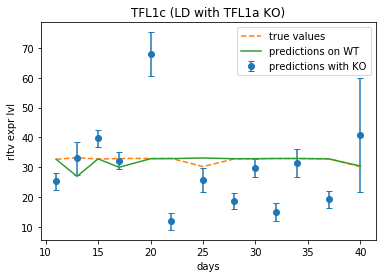

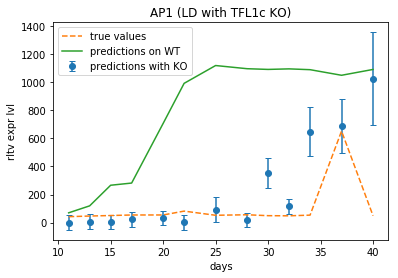

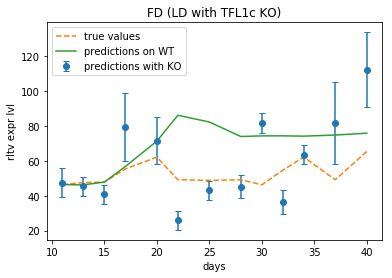

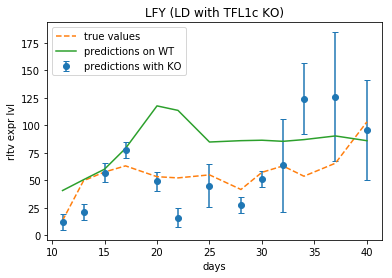

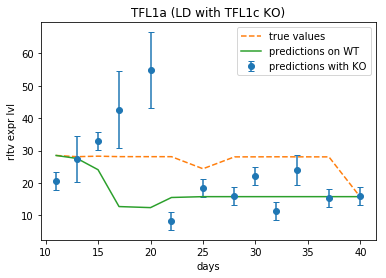

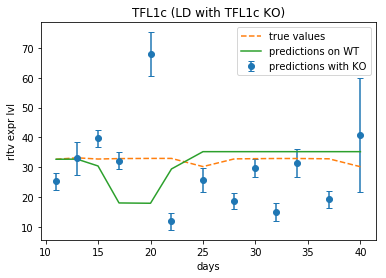

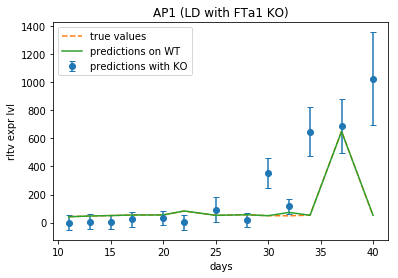

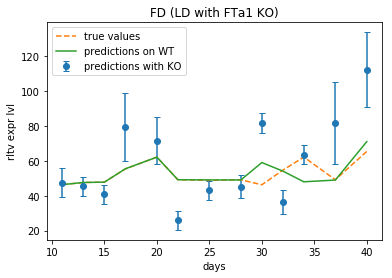

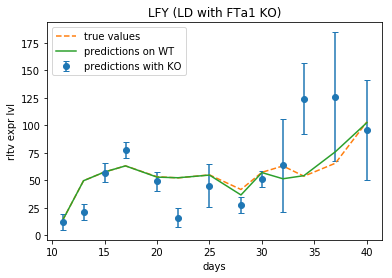

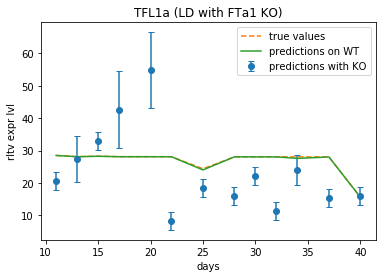

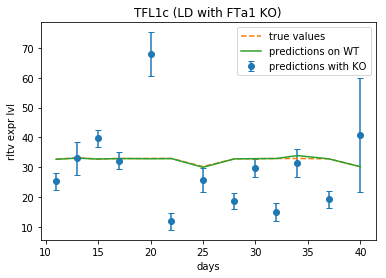

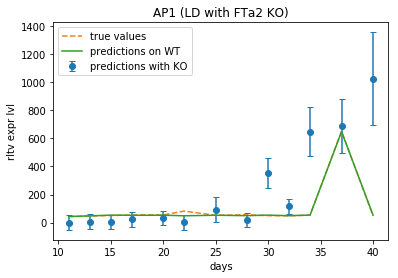

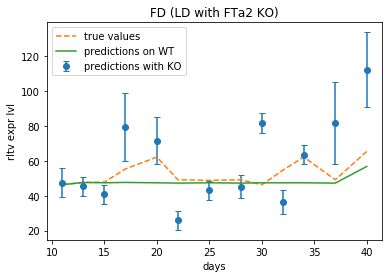

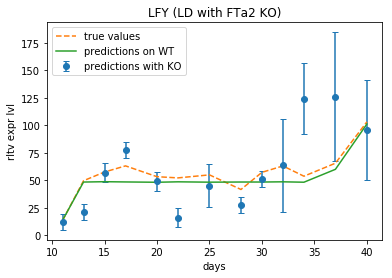

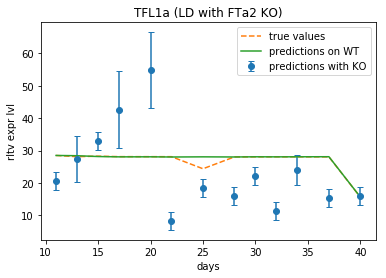

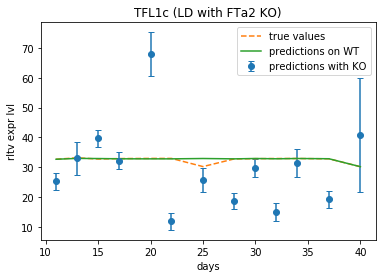

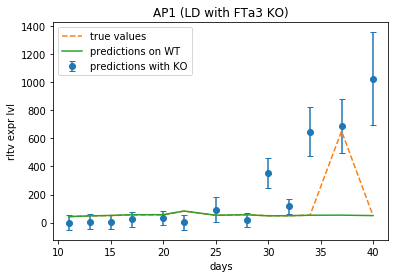

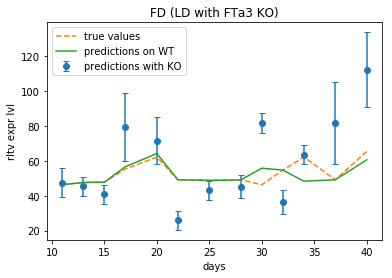

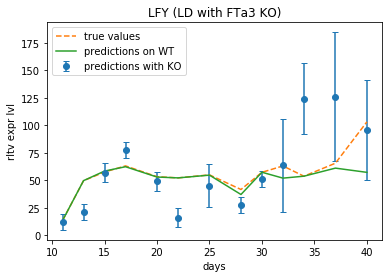

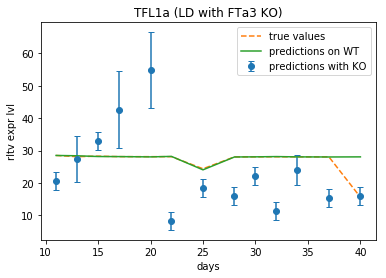

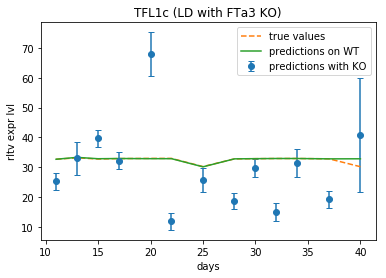

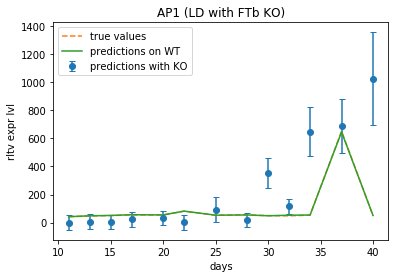

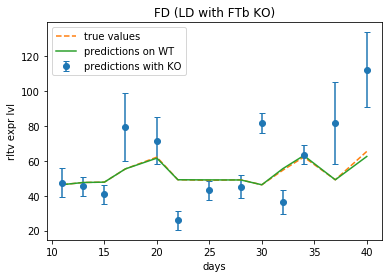

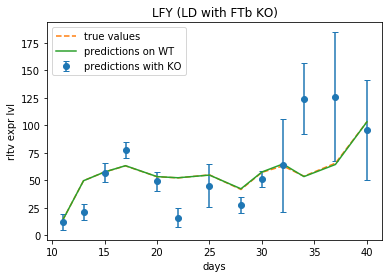

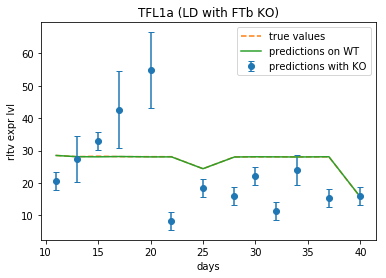

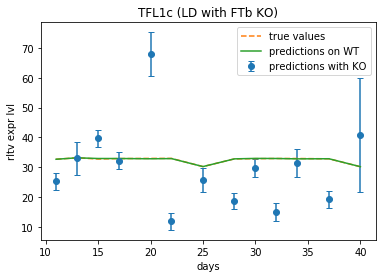

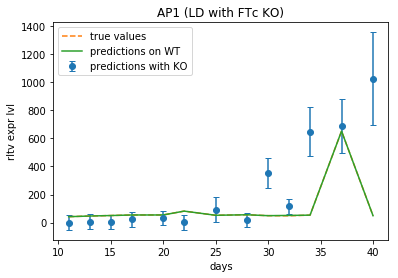

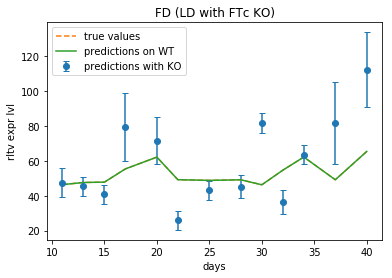

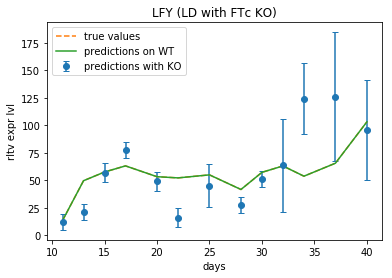

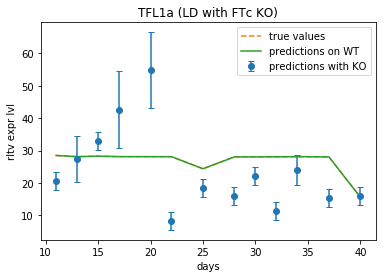

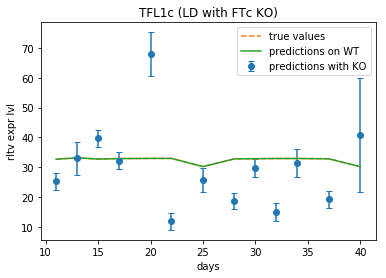

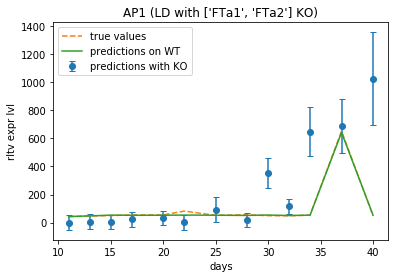

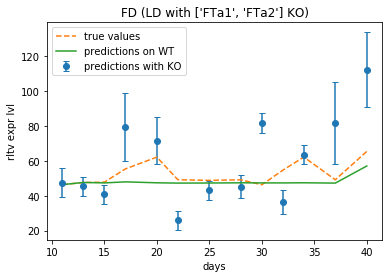

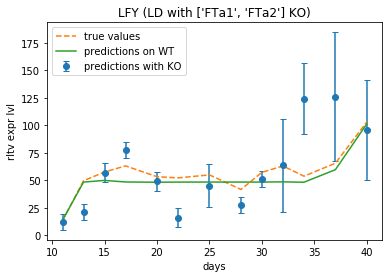

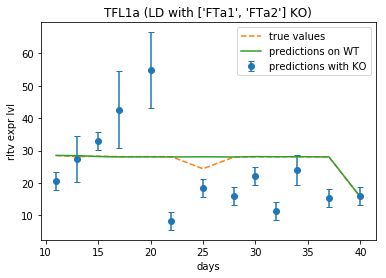

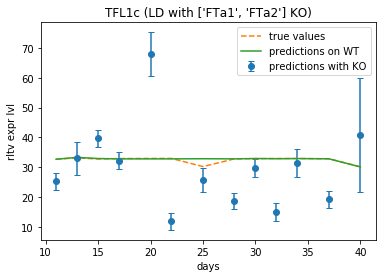

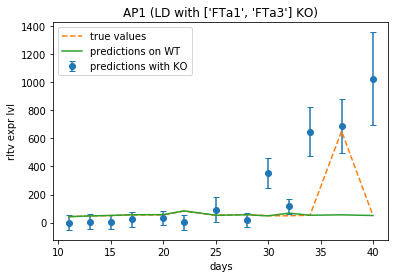

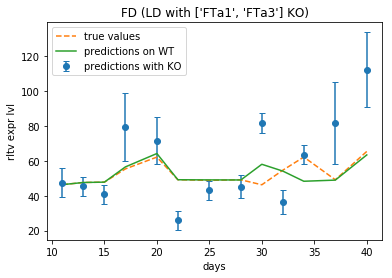

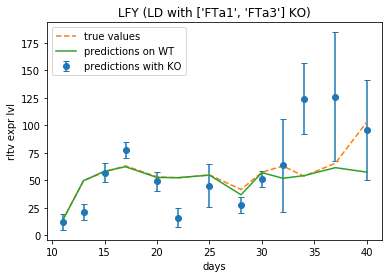

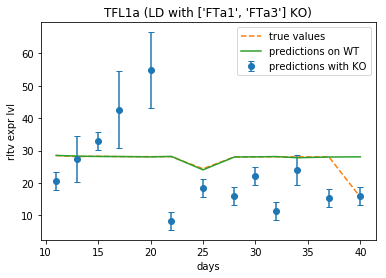

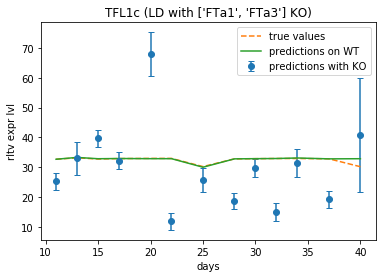

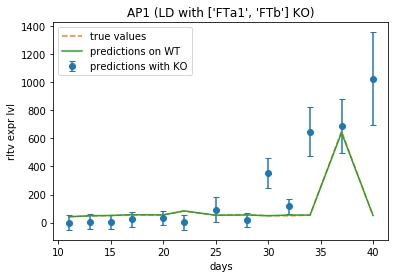

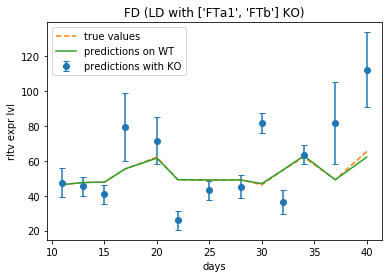

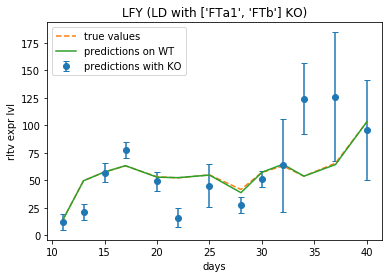

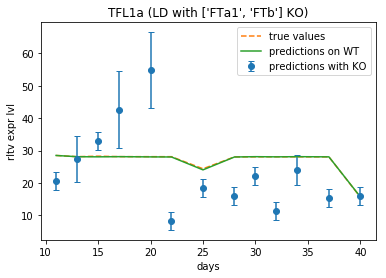

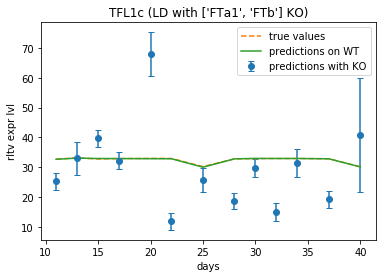

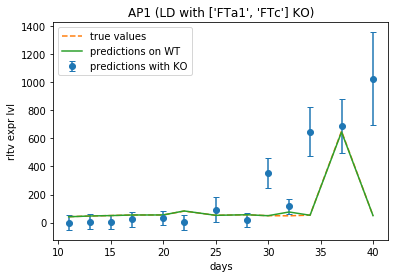

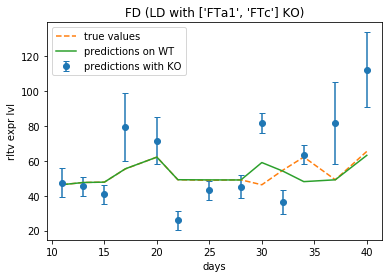

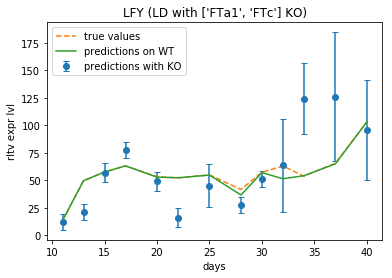

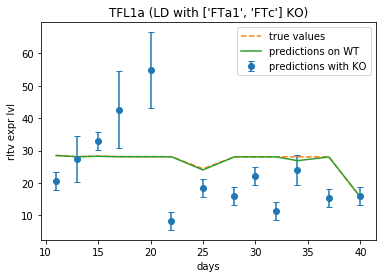

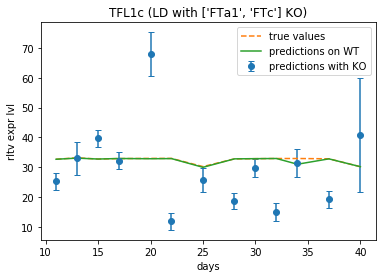

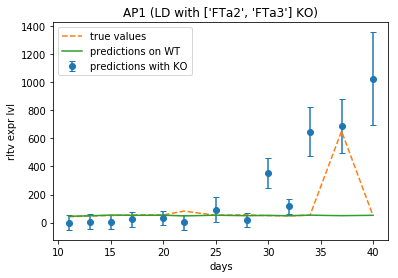

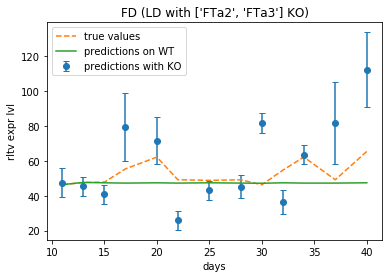

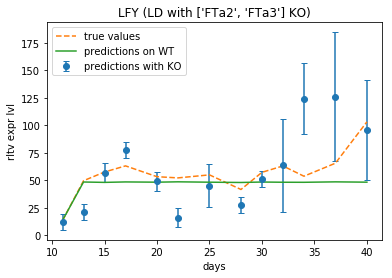

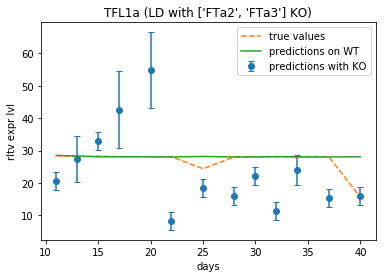

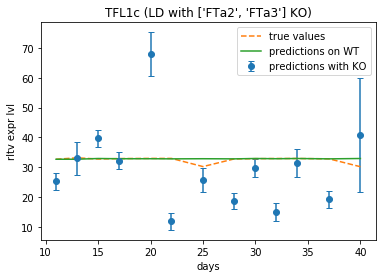

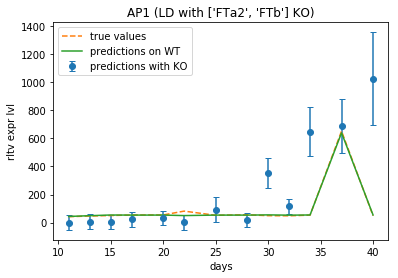

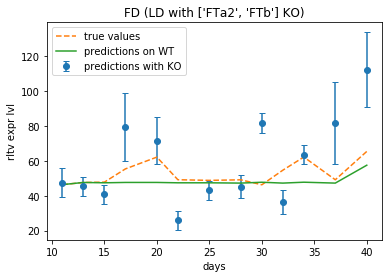

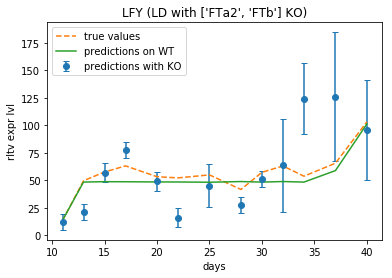

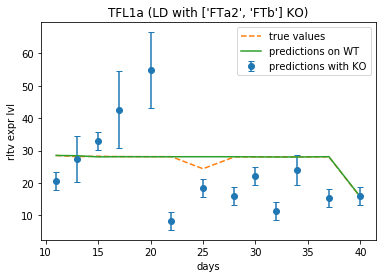

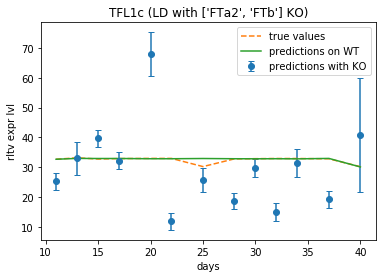

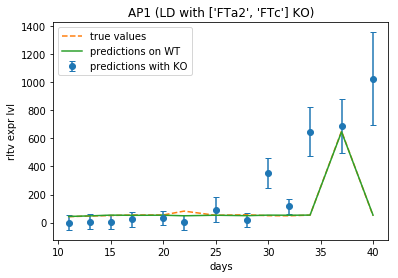

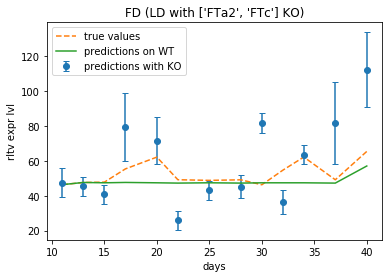

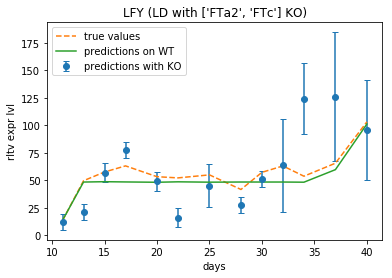

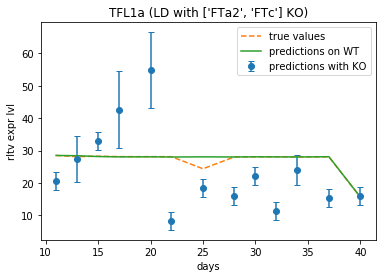

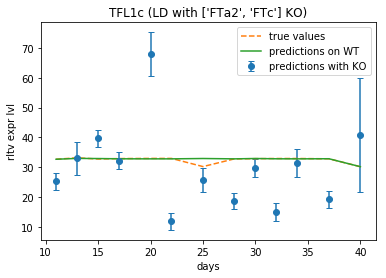

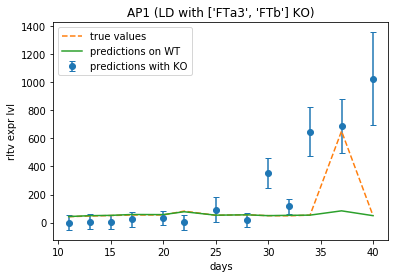

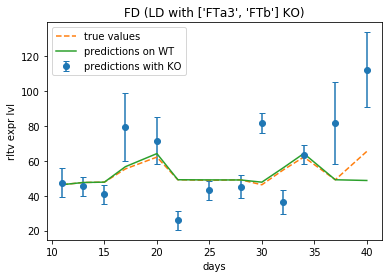

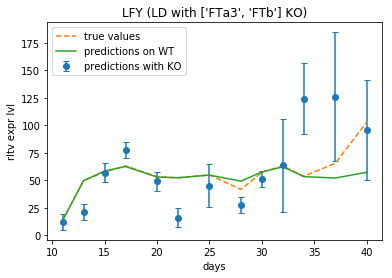

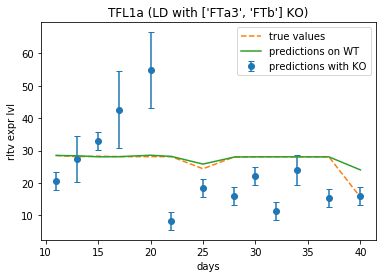

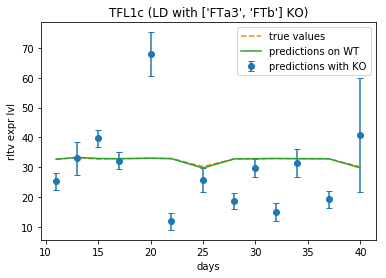

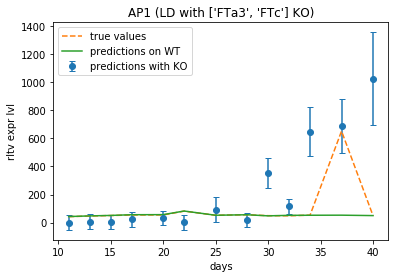

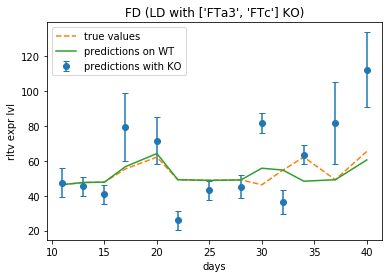

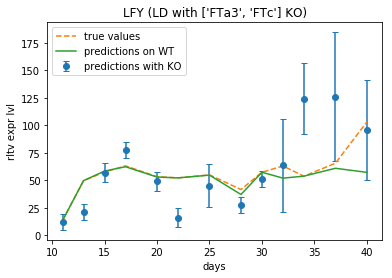

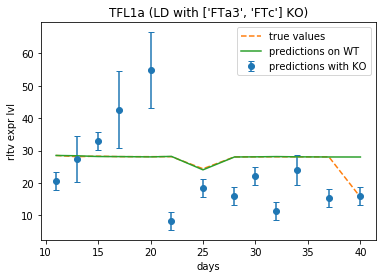

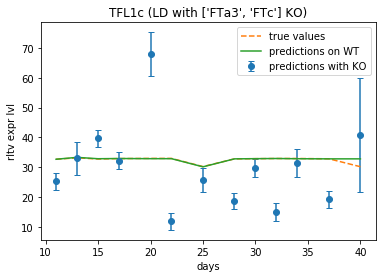

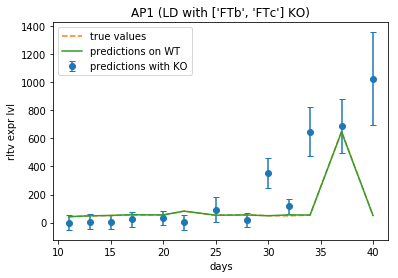

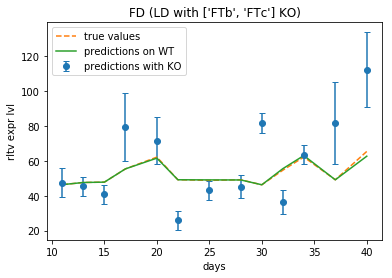

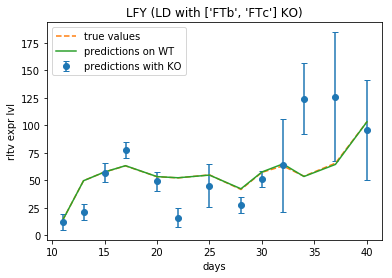

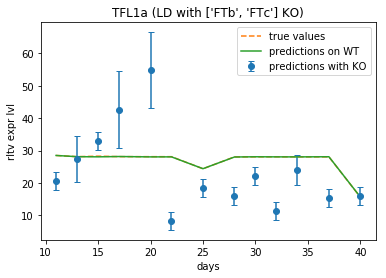

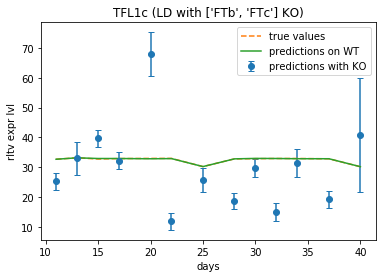

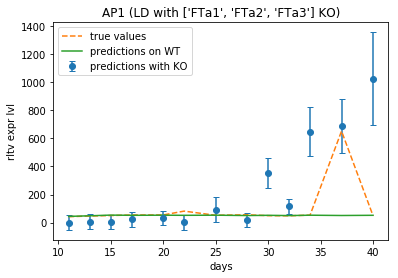

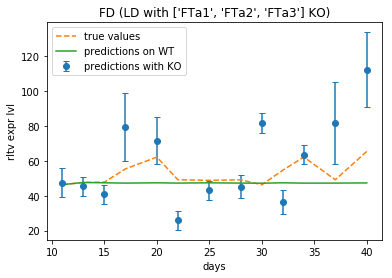

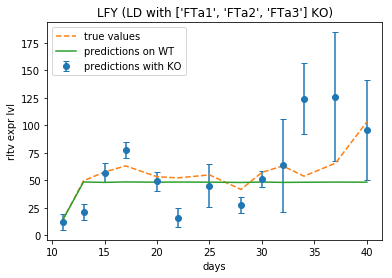

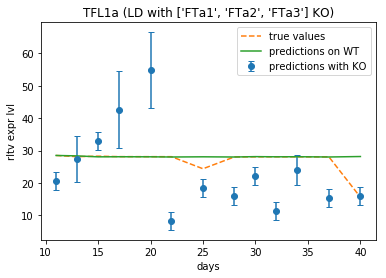

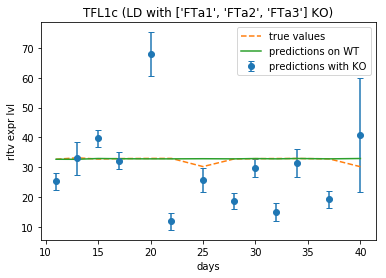

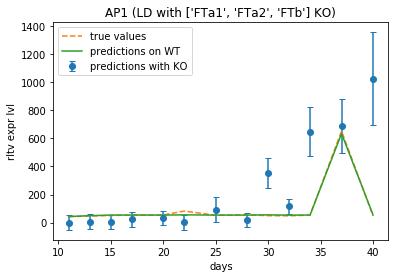

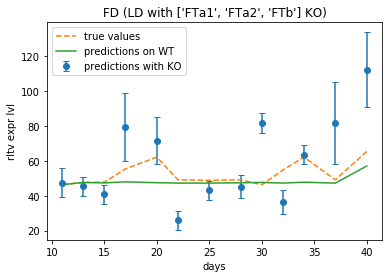

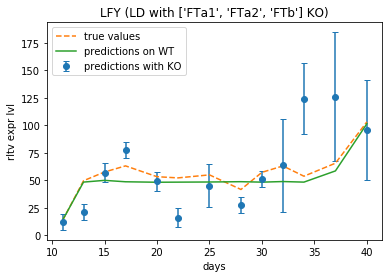

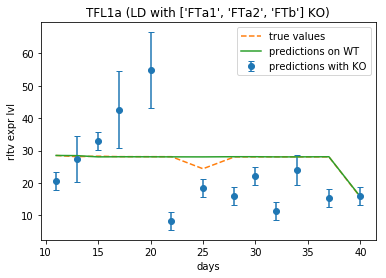

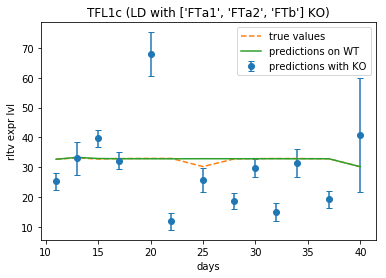

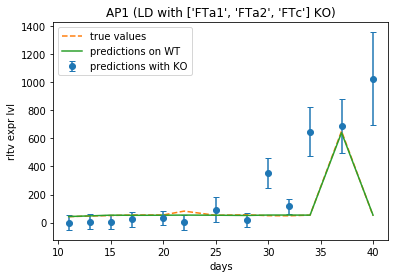

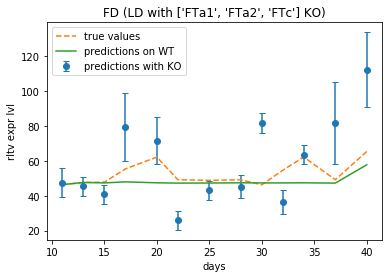

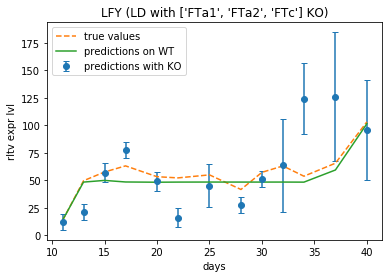

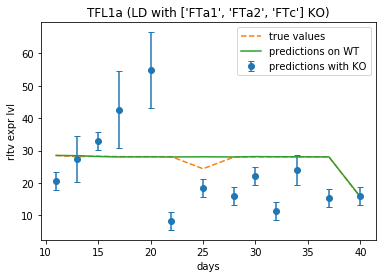

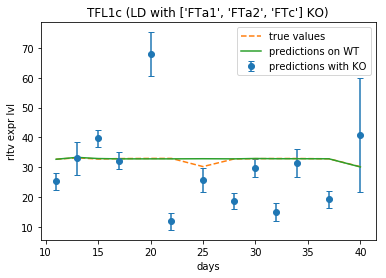

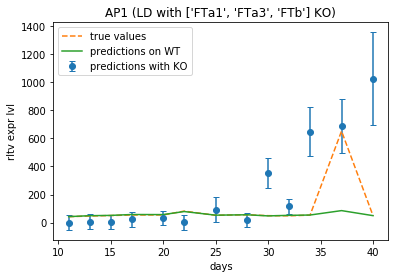

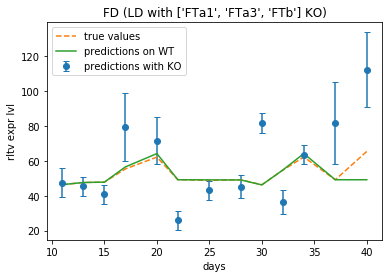

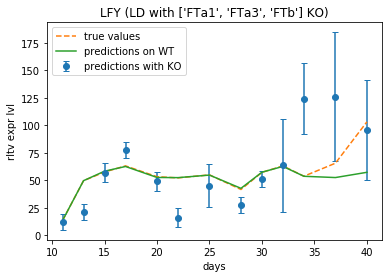

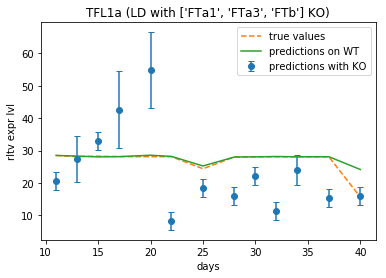

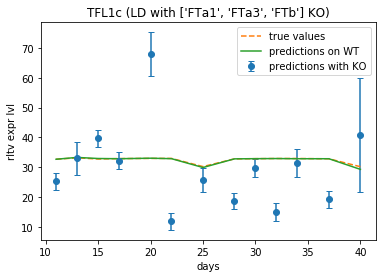

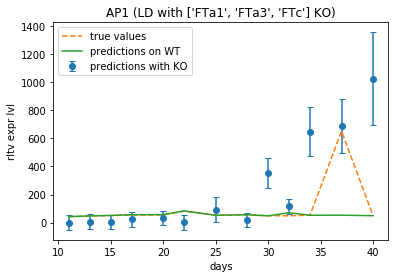

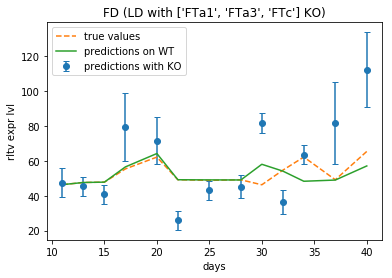

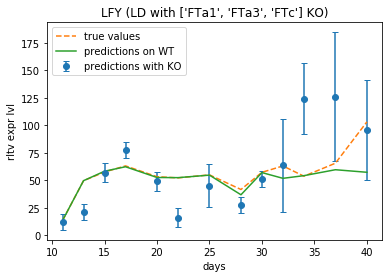

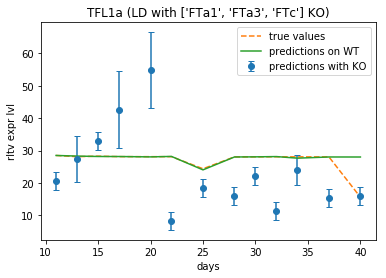

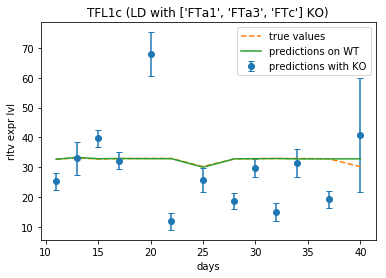

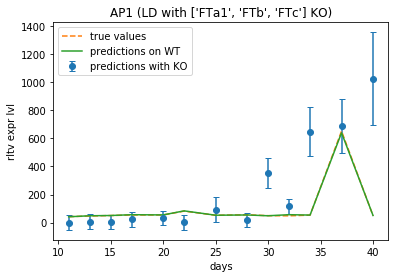

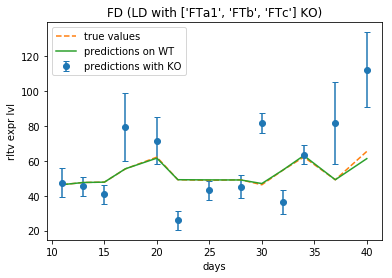

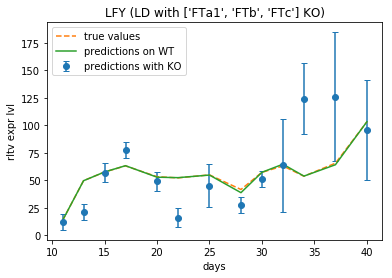

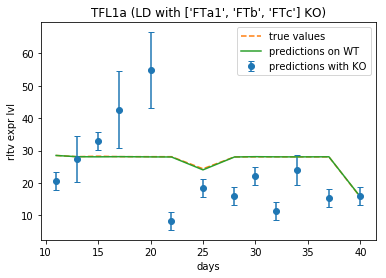

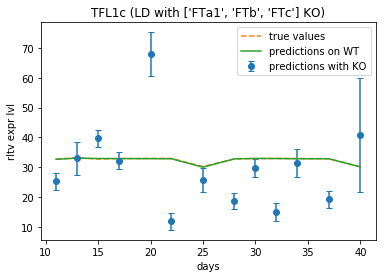

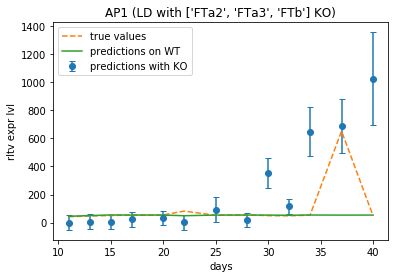

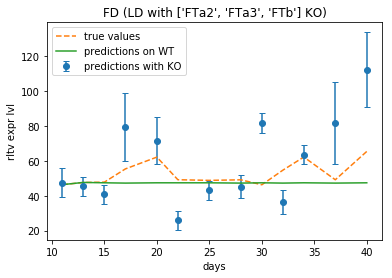

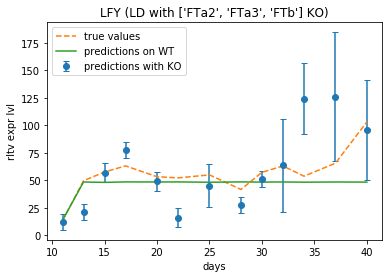

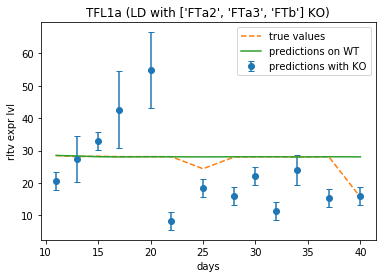

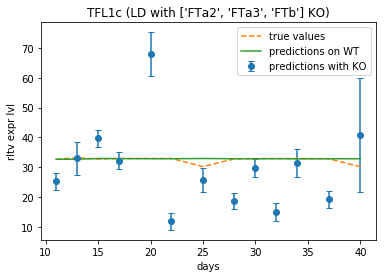

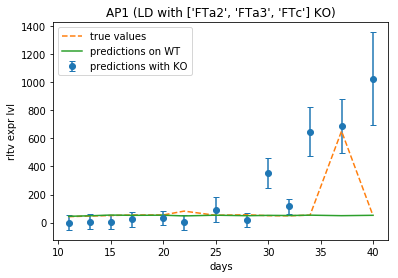

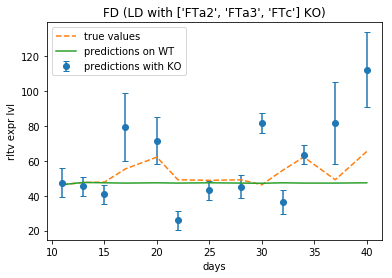

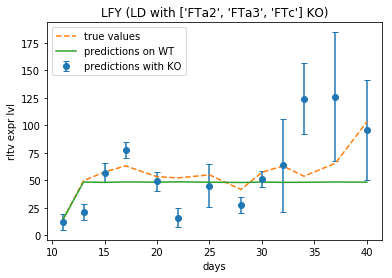

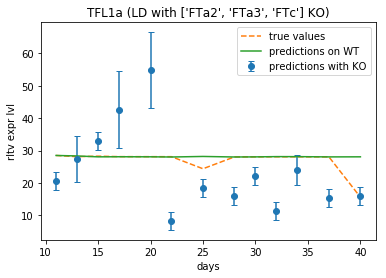

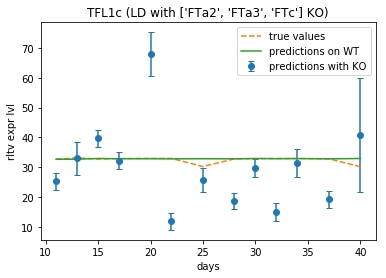

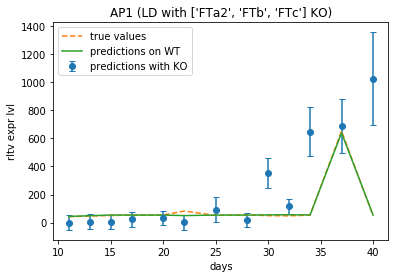

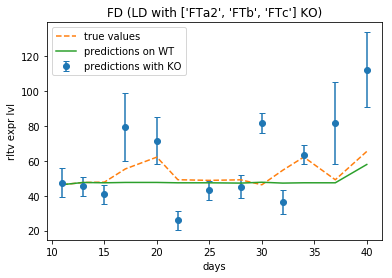

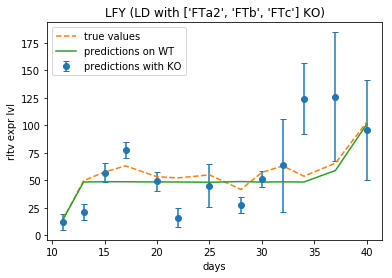

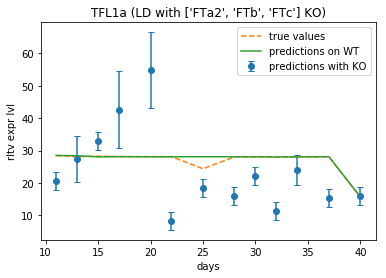

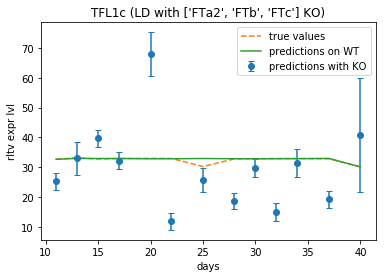

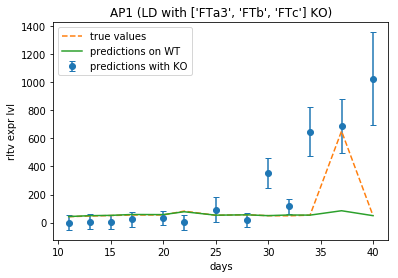

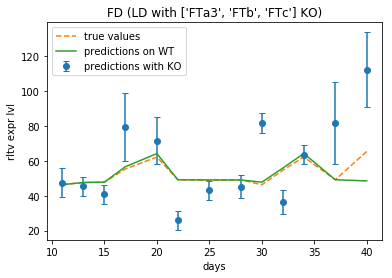

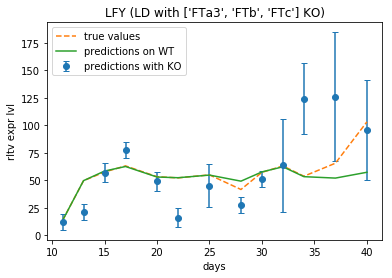

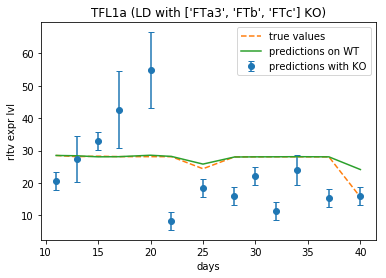

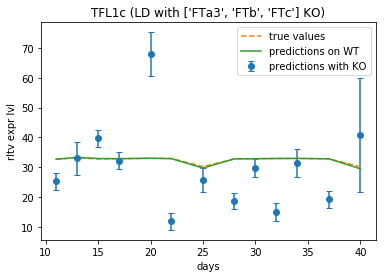

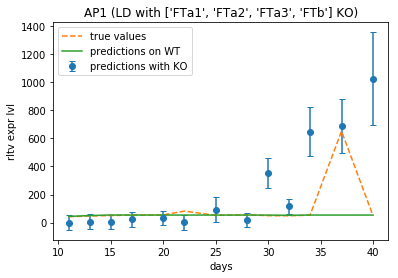

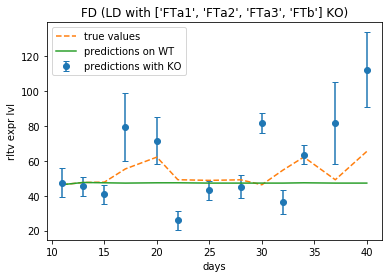

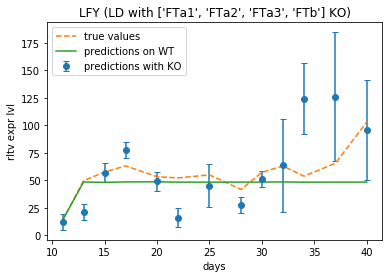

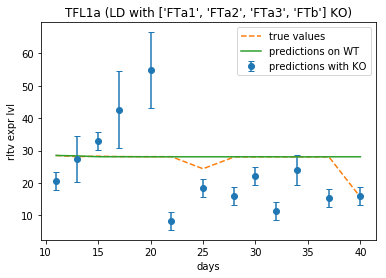

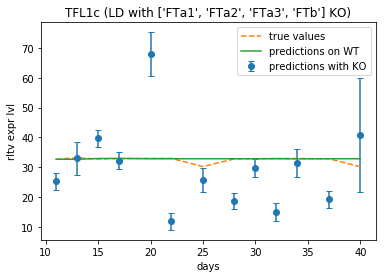

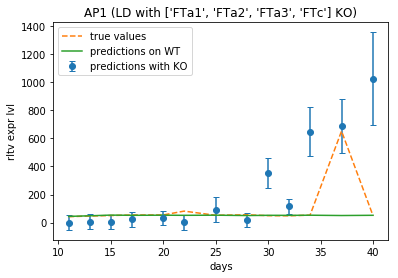

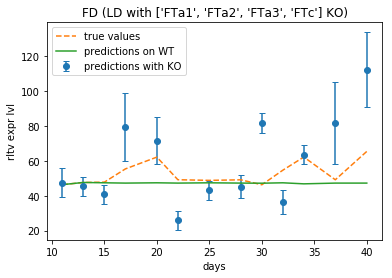

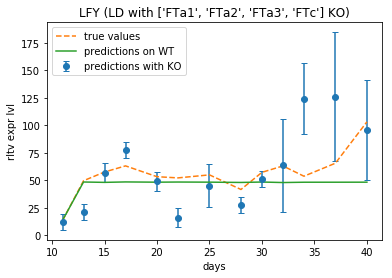

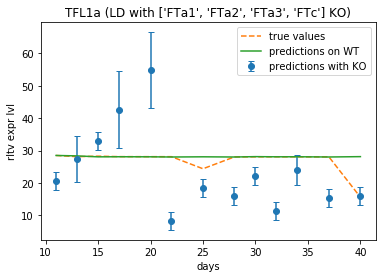

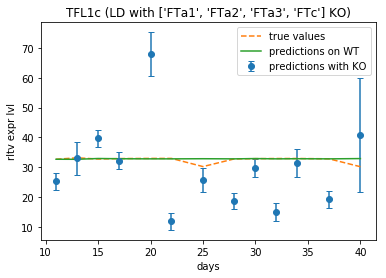

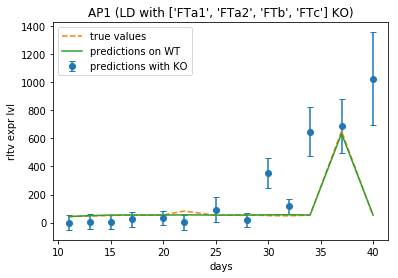

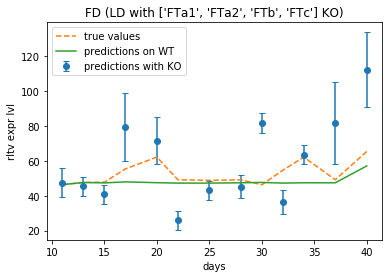

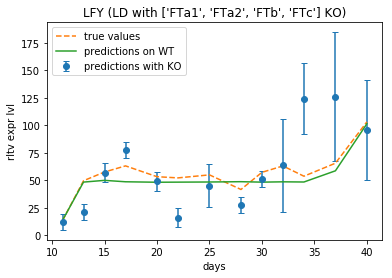

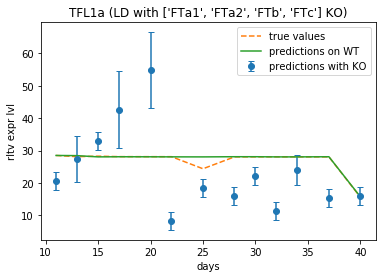

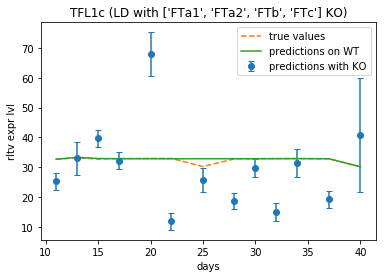

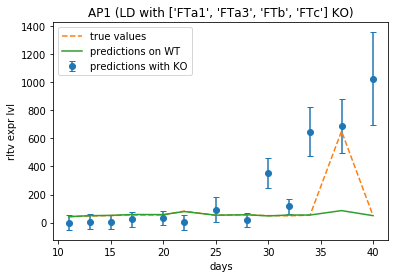

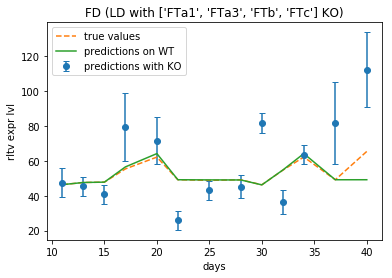

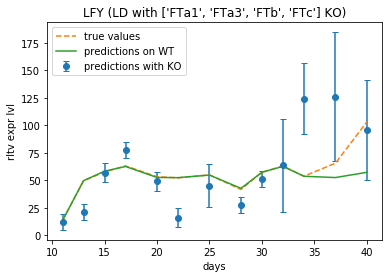

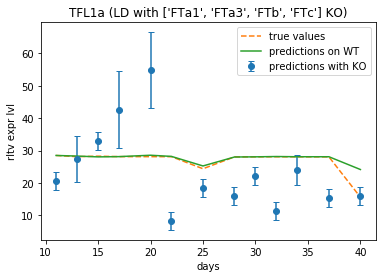

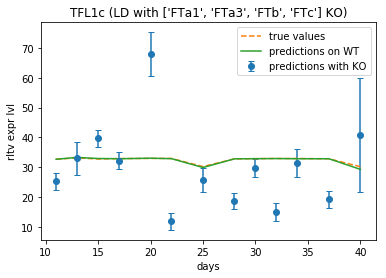

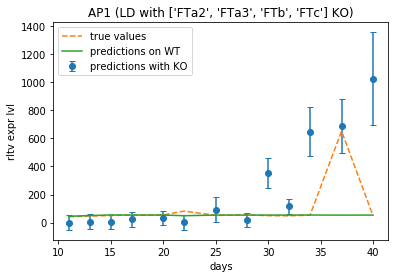

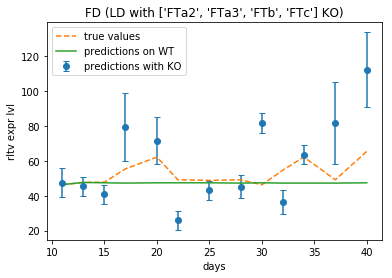

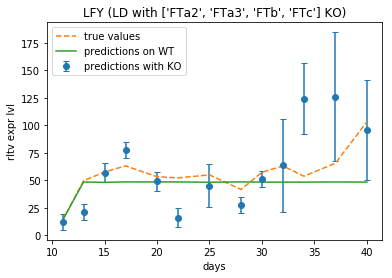

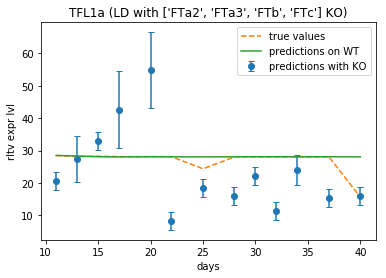

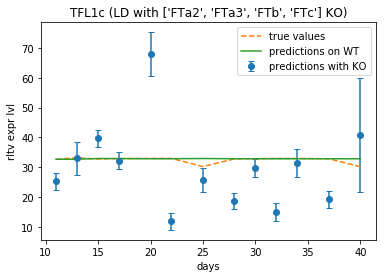

In [20]:
for ko_genes in KO_iterations:
    for cond in conditions:
        for ko_name in ko_genes:
                            
            if type(ko_name) == type((1,)):
                ko_name = list(ko_name)
            
            X_ko = X_real[cond].copy()
            X_ko = X_ko.drop('days', axis = 1)
            
            pred_ko = pd.DataFrame(columns=targets)
            
            for i in range(len(X_ko)):
                X_ko[ko_name] = 0
                current_predictions = predict(X_ko.loc[[i]])
                pred_ko = pred_ko.append(current_predictions, ignore_index = True)
                
                if i < len(X_ko) - 1:
#                     X_ko.loc[[i + 1]][targets] = pred_ko.loc[[i]].values
                    X_ko[targets] = pred_ko.loc[[i]].values[0]
                
            time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
            
            column = str(ko_name)
            
            # AUCs table:
            days_axis = Y_real[cond]['days']
            for i in range(5):
                current_target = targets[i] + '_' + cond
                AUC.loc[current_target, 'WT'] = auc(days_axis, predictions_real[cond].iloc[:, i])
                AUC.loc[current_target, column] = auc(days_axis, pred_ko.iloc[:, i])

In [ ]:
X_ko

In [ ]:
AUC.T

# FT dynamics

In [ ]:
FTs

In [ ]:
X_real['LD']

In [ ]:
for f in FTs:
    plt.plot(X_real['LD'].days, X_real['LD'][f], '-o')
    plt.legend(FTs)

In [ ]:
plt.plot(X_real['LD'].days, X_real['LD']['A'], '-o')
plt.plot(X_real['LD'].days, X_real['LD']['FTa2'], '-o')
plt.legend(['LFY', 'FTa2'])

# AUCs

In [ ]:
# AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [ ]:
AUC.T

In [24]:
AUC_norm = AUC.T / AUC.WT

In [25]:
for col in AUC_norm.columns:
    AUC_norm.loc[col[:-3], col] = 1.

In [26]:
AUC_norm

AP1_LD     FD_LD    LFY_LD  TFL1a_LD  \
WT                               1.000000  1.000000  1.000000  1.000000   
AP1                              1.000000  0.994430  0.976609  1.062792   
FD                               0.947352  1.000000  0.885885  1.017415   
LFY                              1.067893  0.898556  1.000000  1.017276   
TFL1a                            1.053988  0.936499  0.981770  1.000000   
TFL1c                            7.075441  1.325575  1.501803  0.628511   
FTa1                             1.013173  0.998453  0.996491  0.996589   
FTa2                             0.972329  0.909267  0.902157  1.014029   
FTa3                             0.469963  0.990406  0.928597  1.022942   
FTb                              1.000197  0.999035  1.001081  0.999221   
FTc                              1.001612  1.000000  1.000045  1.000249   
['FTa1', 'FTa2']                 0.972171  0.909818  0.902879  1.014433   
['FTa1', 'FTa3']                 0.483560  0.995234  0.928830  1.021906   
['FTa1', 'FTb']                  0.997036  0.998573  0.995019  0.997958   
['FTa1', 'FTc']                  1.010550  0.991166  0.976943  0.994433   
['FTa2', 'FTa3']                 0.435606  0.898805  0.831176  1.037718   
['FTa2', 'FTb']                  0.977328  0.911290  0.901541  1.014435   
['FTa2', 'FTc']                  0.973114  0.909496  0.901395  1.013843   
['FTa3', 'FTb']                  0.499188  0.996203  0.943702  1.023291   
['FTa3', 'FTc']                  0.471239  0.990326  0.928395  1.022903   
['FTb', 'FTc']                   1.001674  0.999171  1.001344  0.999317   
['FTa1', 'FTa2', 'FTa3']         0.441480  0.898711  0.830547  1.037592   
['FTa1', 'FTa2', 'FTb']          0.975934  0.910578  0.902069  1.014375   
['FTa1', 'FTa2', 'FTc']          0.973280  0.910493  0.902241  1.014297   
['FTa1', 'FTa3', 'FTb']          0.501116  0.992893  0.934449  1.021546   
['FTa1', 'FTa3', 'FTc']          0.482514  0.989082  0.925256  1.021417   
['FTa1', 'FTb', 'FTc']           0.998048  0.997879  0.994936  0.997814   
['FTa2', 'FTa3', 'FTb']          0.452253  0.899463  0.832314  1.037672   
['FTa2', 'FTa3', 'FTc']          0.436560  0.898795  0.830777  1.037946   
['FTa2', 'FTb', 'FTc']           0.979027  0.911506  0.901571  1.014569   
['FTa3', 'FTb', 'FTc']           0.501371  0.995997  0.943522  1.023659   
['FTa1', 'FTa2', 'FTa3', 'FTb']  0.455854  0.898723  0.832059  1.037983   
['FTa1', 'FTa2', 'FTa3', 'FTc']  0.442218  0.897930  0.830184  1.037489   
['FTa1', 'FTa2', 'FTb', 'FTc']   0.977661  0.910427  0.902110  1.014361   
['FTa1', 'FTa3', 'FTb', 'FTc']   0.502508  0.992893  0.934447  1.021561   
['FTa2', 'FTa3', 'FTb', 'FTc']   0.453054  0.899181  0.832261  1.037852   

                                 TFL1c_LD  
WT                               1.000000  
AP1                              1.007693  
FD                               1.007867  
LFY                              1.007364  
TFL1a                            0.988265  
TFL1c                            1.000000  
FTa1                             1.001184  
FTa2                             1.007530  
FTa3                             1.004038  
FTb                              0.999892  
FTc                              0.999996  
['FTa1', 'FTa2']                 1.007744  
['FTa1', 'FTa3']                 1.004071  
['FTa1', 'FTb']                  0.999009  
['FTa1', 'FTc']                  0.993487  
['FTa2', 'FTa3']                 1.011211  
['FTa2', 'FTb']                  1.007908  
['FTa2', 'FTc']                  1.007215  
['FTa3', 'FTb']                  0.998070  
['FTa3', 'FTc']                  1.003806  
['FTb', 'FTc']                   1.000021  
['FTa1', 'FTa2', 'FTa3']         1.010893  
['FTa1', 'FTa2', 'FTb']          1.008030  
['FTa1', 'FTa2', 'FTc']          1.007604  
['FTa1', 'FTa3', 'FTb']          0.997919  
['FTa1', 'FTa3', 'FTc']          1.003218  
['FTa1', 'FTb', 'FTc']           0.998827  
['FTa2', 'FTa3', 'FTb']    

## Heatmap

In [27]:
def my_heatmap(data, figsize = (15, 5), format='svg'):
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(data, robust = True, center = 1, cmap='RdBu_r')
    plt.xlabel('KO genes')
    plt.ylabel('AUC relative to WT AUC')
    
    fig_path = results_path + 'dynamic/'

    if not os.path.exists(fig_path):
        os.makedirs(fig_path)

    plt.savefig(fig_path + f'Heatmap.{format}', bbox_inches='tight', format=format, dpi=300)

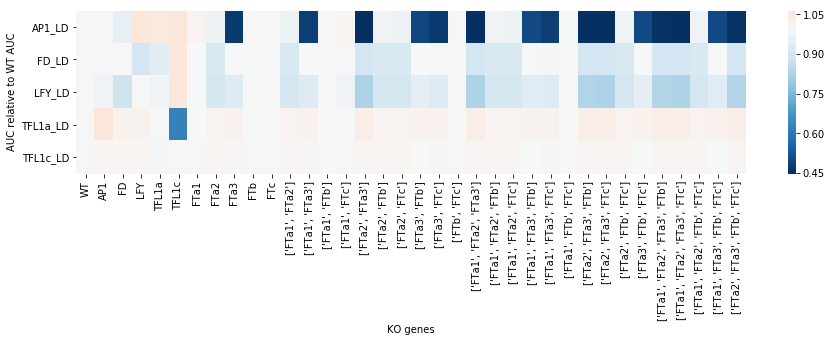

In [28]:
my_heatmap(AUC_norm.T, figsize=(15, 3))

## Barplots

In [29]:
def AUC_barplots(dataframe, format='svg'):
    for index in dataframe.index:
        df = dataframe.drop([index[:-3], 'WT'], axis=1)
        df.loc[index] = df.loc[index] / dataframe.loc[index, 'WT']
        col = df.columns
        
        plt.figure(figsize=(20,10))

        myplot = sns.barplot(y = index, x = col, data = df.T)
        plt.xticks(rotation=60)
        plt.xlabel('KO genes')
        plt.ylabel('KO/WT transcription level')
        plt.title(index.replace('_', ' '))
        myplot.axes.axhline(1, dashes=(5, 1))
        
        fig_path = results_path + 'dynamic/barplots/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{index}.{format}', bbox_inches='tight', format=format, dpi=300)
        plt.show()

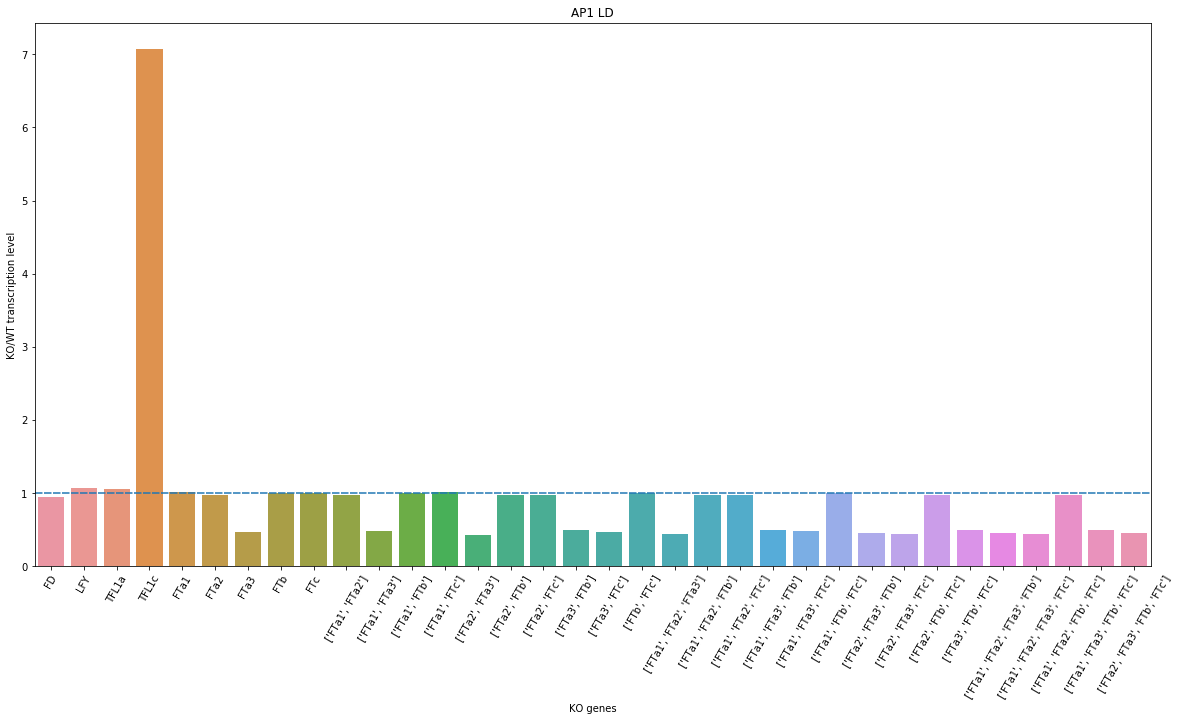

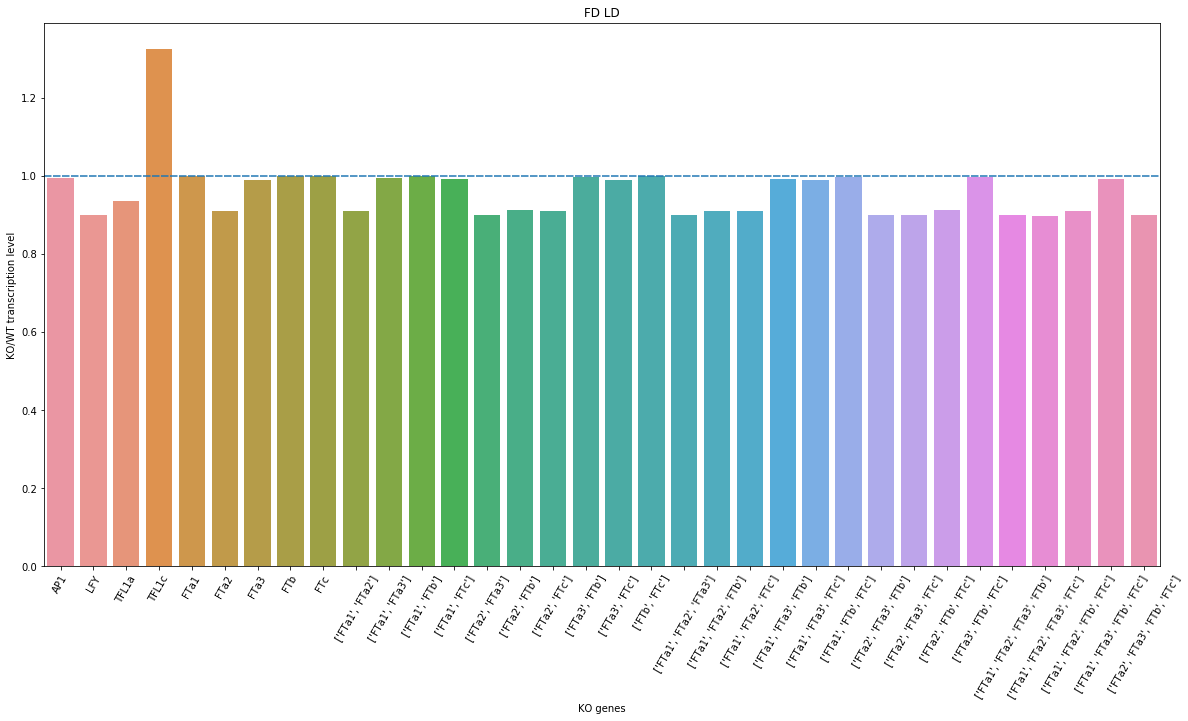

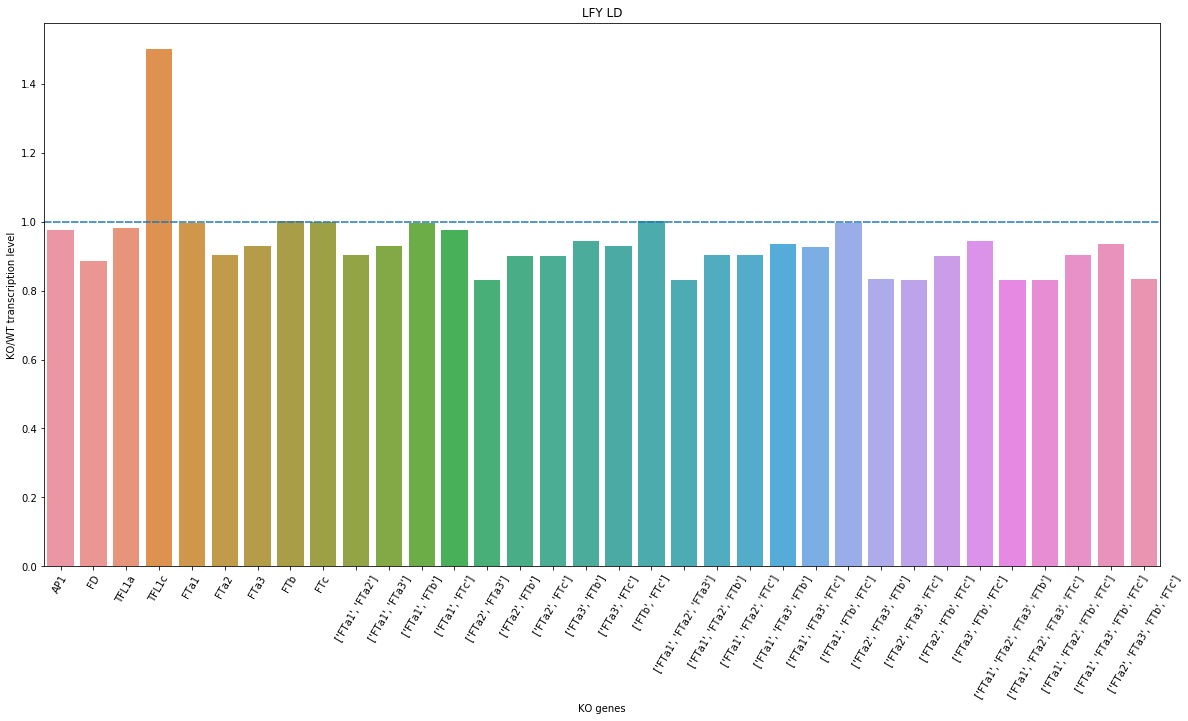

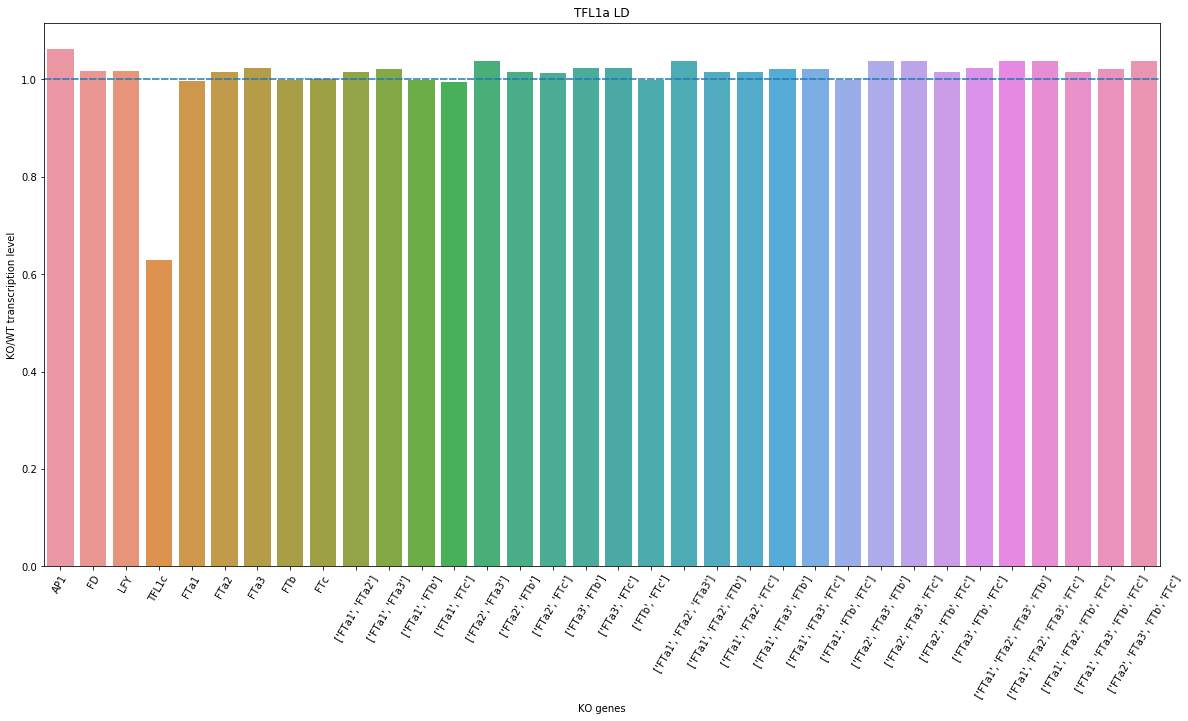

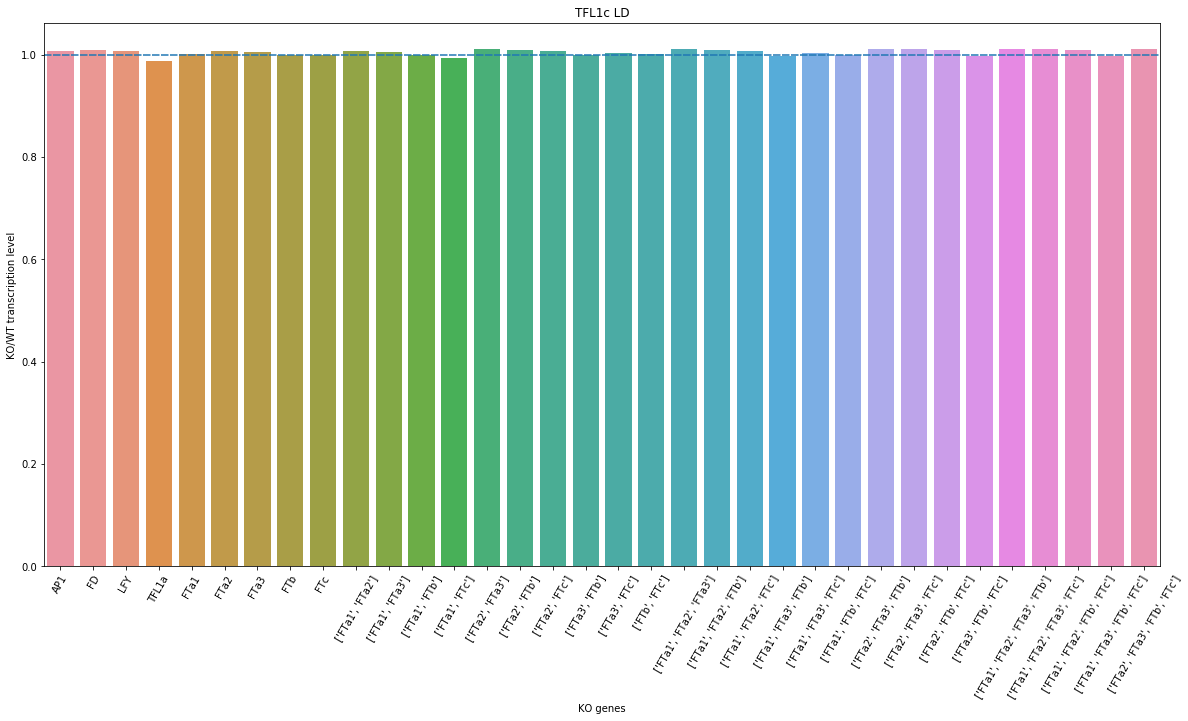

In [30]:
AUC_barplots(AUC)

In [ ]:
for f in ['FTb', 'FTa1', 'FTa3', 'FTa1_FTb']:
    myplot = sns.barplot(y = (AUC.T.loc[f,]/AUC.T.loc['WT',]).tolist(), x = AUC.T.columns)
    plt.xticks(rotation=60)
    myplot.axes.axhline(1, dashes=(5, 1))
    plt.title(f)
    plt.show()

# Save and load the model

In [21]:
dill.dump_session('cache/Reduced_model_LD_only.db')

In [3]:
dill.load_session('cache/Reduced_model_LD_only.db')

# Some trash

In [ ]:
# import torch

In [ ]:
# model_save_name = 'RF_regressor.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# model_path = data_path + model_save_name
# torch.save(total_model.state_dict(), model_path)

In [ ]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
# def clear_log():
#     with open('results/NN/NN_log.txt', 'w') as out_file:
#         out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))